<a href="https://colab.research.google.com/github/bondpy202212/AI_projects/blob/main/_10___NLP_avoid_Overfitting(Sentiment140_dataset)_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Imports**

In [ ]:
import csv
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

**Download the Sentiment140 dataset**\
https://www.kaggle.com/datasets/kazanova/sentiment140 \
This is the sentiment140 dataset. It contains 1,600,000 tweets extracted using the twitter api . The tweets have been annotated (0 = negative, 4 = positive) and they can be used to detect sentiment .

In [ ]:
!kaggle datasets download -d kazanova/sentiment140

Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
License(s): other
 91% 74.0M/80.9M [00:01<00:00, 77.9MB/s]
100% 80.9M/80.9M [00:01<00:00, 69.4MB/s]


In [ ]:
!unzip sentiment140.zip

Archive:  sentiment140.zip
  inflating: training.1600000.processed.noemoticon.csv  


In [ ]:
SENTIMENT_CSV = "./training.1600000.processed.noemoticon.csv"

**Download "glove.6B.zip" for pre-defined Embeddings**\
https://nlp.stanford.edu/projects/glove/ <!--
gdown.download(url ='https://nlp.stanford.edu/data/glove.6B.zip',
               output= './glove.6B.zip')
!unzip glove.6B.zip
--> \
https://www.kaggle.com/datasets/sawarn69/glove6b100dtxt \
GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space. \
6B tokens, 400K vocab, uncased, 50d, 100d, 200d, & 300d vectors


In [ ]:
!kaggle datasets download -d sawarn69/glove6b100dtxt

Dataset URL: https://www.kaggle.com/datasets/sawarn69/glove6b100dtxt
License(s): unknown
100% 131M/131M [00:01<00:00, 82.2MB/s]
100% 131M/131M [00:01<00:00, 92.9MB/s]


In [ ]:
!unzip glove6b100dtxt.zip

Archive:  glove6b100dtxt.zip
  inflating: glove.6B.100d.txt       


In [ ]:
GLOVE_FILE = './glove.6B.100d.txt'

**Explore the dataset**\
The dataset is provided in a csv file.

Each row of this file contains the following values separated by commas:

target: the polarity of the tweet (0 = negative, 4 = positive)

ids: The id of the tweet

date: the date of the tweet

flag: The query. If there is no query, then this value is NO_QUERY.

user: the user that tweeted

text: the text of the tweet

In [ ]:
SENTIMENT_CSV = SENTIMENT_CSV


with open(SENTIMENT_CSV, 'r') as csvfile:
    print(f"First data point looks like this:\n\n{csvfile.readline()}")
    print(f"Second data point looks like this:\n\n{csvfile.readline()}")
    print(f"Next data point looks like this:\n\n{csvfile.readline()}")
    print(f"Next data point looks like this:\n\n{csvfile.readline()}")
    print(f"Next data point looks like this:\n\n{csvfile.readline()}")

First data point looks like this:

"0","1467810369","Mon Apr 06 22:19:45 PDT 2009","NO_QUERY","_TheSpecialOne_","@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

Second data point looks like this:

"0","1467810672","Mon Apr 06 22:19:49 PDT 2009","NO_QUERY","scotthamilton","is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!"

Next data point looks like this:

"0","1467810917","Mon Apr 06 22:19:53 PDT 2009","NO_QUERY","mattycus","@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds"

Next data point looks like this:

"0","1467811184","Mon Apr 06 22:19:57 PDT 2009","NO_QUERY","ElleCTF","my whole body feels itchy and like its on fire "

Next data point looks like this:

"0","1467811193","Mon Apr 06 22:19:57 PDT 2009","NO_QUERY","Karoli","@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't se

**Defining some useful global variables**

In [ ]:
EMBEDDING_DIM = 100
MAXLEN = 16
TRUNCATING = 'post'
PADDING = 'post'
OOV_TOKEN = "<OOV>"
MAX_EXAMPLES = 160000
TRAINING_SPLIT = 0.9

**Parsing the raw data**\
The labels are originally encoded as strings ('0' representing negative and '4' representing positive). Change this so that the labels are integers and 0 is used for representing negative, while 1 should represent positive.

In [ ]:
def parse_data_from_file(filename):
    """
    Extracts sentences and labels from a CSV file

    Args:
        filename (string): path to the CSV file

    Returns:
        sentences, labels (list of string, list of string): tuple containing lists of sentences and labels
    """

    sentences = []
    labels = []

    with open(filename, 'r', errors='ignore') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        for row in reader:
            labels.append(1 if row[0] == '4' else 0)
            sentences.append(row[5])

    return sentences, labels



In [ ]:
# Test function
sentences, labels = parse_data_from_file(SENTIMENT_CSV)

print(f"dataset contains {len(sentences)} examples\n")

print(f"Text of second example should look like this:\n{sentences[1]}\n")
print(f"Text of fourth example should look like this:\n{sentences[3]}")

print(f"\nLabels of last 5 examples should look like this:\n{labels[-5:]}")

dataset contains 1600000 examples

Text of second example should look like this:
is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!

Text of fourth example should look like this:
my whole body feels itchy and like its on fire 

Labels of last 5 examples should look like this:
[1, 1, 1, 1, 1]


**To reduce execution time, only 10% of the original data will be used.**

In [ ]:
# Bundle the two lists into a single one
sentences_and_labels = list(zip(sentences, labels))

# Perform random sampling
random.seed(42)
sentences_and_labels = random.sample(sentences_and_labels, MAX_EXAMPLES)

# Unpack back into separate lists
sentences, labels = zip(*sentences_and_labels)

print(f"There are {len(sentences)} sentences and {len(labels)} labels after random sampling\n")

There are 160000 sentences and 160000 labels after random sampling



**Training - Validation Split**

In [ ]:
def train_val_split(sentences, labels, training_split):
    """
    Splits the dataset into training and validation sets

    Args:
        sentences (list of string): lower-cased sentences without stopwords
        labels (list of string): list of labels
        training split (float): proportion of the dataset to convert to include in the train set

    Returns:
        train_sentences, validation_sentences, train_labels, validation_labels - lists containing the data splits
    """

    # Compute the number of sentences that will be used for training (should be an integer)
    train_size = int(len(sentences) * training_split)

    # Split the sentences and labels into train/validation splits
    train_sentences = sentences[:train_size]
    train_labels = labels[:train_size]

    validation_sentences = sentences[train_size:]
    validation_labels = labels[train_size:]

    return train_sentences, validation_sentences, train_labels, validation_labels

In [ ]:
# Test function
train_sentences, val_sentences, train_labels, val_labels = train_val_split(sentences, labels, TRAINING_SPLIT)

print(f"There are {len(train_sentences)} sentences for training.\n")
print(f"There are {len(train_labels)} labels for training.\n")
print(f"There are {len(val_sentences)} sentences for validation.\n")
print(f"There are {len(val_labels)} labels for validation.")

There are 144000 sentences for training.

There are 144000 labels for training.

There are 16000 sentences for validation.

There are 16000 labels for validation.


**Tokenization - Sequences, truncating and padding**

In [ ]:
def fit_tokenizer(train_sentences, oov_token):
    """
    Instantiates the Tokenizer class on the training sentences

    Args:
        train_sentences (list of string): lower-cased sentences without stopwords to be used for training
        oov_token (string) - symbol for the out-of-vocabulary token

    Returns:
        tokenizer (object): an instance of the Tokenizer class containing the word-index dictionary
    """

    # Instantiate the Tokenizer class, passing in the correct values for oov_token
    tokenizer = Tokenizer(oov_token=oov_token)

    # Fit the tokenizer to the training sentences
    tokenizer.fit_on_texts(train_sentences)

    return tokenizer

In [ ]:
# Test function
tokenizer = fit_tokenizer(train_sentences, OOV_TOKEN)

word_index = tokenizer.word_index
VOCAB_SIZE = len(word_index)

print(f"Vocabulary contains {VOCAB_SIZE} words\n")
print("<OOV> token included in vocabulary" if "<OOV>" in word_index else "<OOV> token NOT included in vocabulary")
print(f"\nindex of word 'i' should be {word_index['i']}")

Vocabulary contains 128158 words

<OOV> token included in vocabulary

index of word 'i' should be 2


In [ ]:
def seq_pad_and_trunc(sentences, tokenizer, padding, truncating, maxlen):
    """
    Generates an array of token sequences and pads them to the same length

    Args:
        sentences (list of string): list of sentences to tokenize and pad
        tokenizer (object): Tokenizer instance containing the word-index dictionary
        padding (string): type of padding to use
        truncating (string): type of truncating to use
        maxlen (int): maximum length of the token sequence

    Returns:
        pad_trunc_sequences (array of int): tokenized sentences padded to the same length
    """

    # Convert sentences to sequences
    sequences = tokenizer.texts_to_sequences(sentences)

    # Pad the sequences using the correct padding, truncating and maxlen
    pad_trunc_sequences = pad_sequences(sequences,
                                       padding=padding,
                                       truncating=truncating,
                                       maxlen=maxlen)

    return pad_trunc_sequences

In [ ]:
# Test function
train_pad_trunc_seq = seq_pad_and_trunc(train_sentences, tokenizer, PADDING, TRUNCATING, MAXLEN)
val_pad_trunc_seq = seq_pad_and_trunc(val_sentences, tokenizer, PADDING, TRUNCATING, MAXLEN)

print(f"Padded and truncated training sequences have shape: {train_pad_trunc_seq.shape}\n")
print(f"Padded and truncated validation sequences have shape: {val_pad_trunc_seq.shape}")

Padded and truncated training sequences have shape: (144000, 16)

Padded and truncated validation sequences have shape: (16000, 16)


**Convert train_labels, val_labels numpy arrays**

In [ ]:
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)

**Using pre-defined Embeddings**\
Using pre-trained word vectors the 100 dimension version of GloVe from Stanford.

In [ ]:
# Define path to file containing the embeddings
GLOVE_FILE = GLOVE_FILE

# Initialize an empty embeddings index dictionary
GLOVE_EMBEDDINGS = {}

# Read file and fill GLOVE_EMBEDDINGS with its contents
with open(GLOVE_FILE) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        GLOVE_EMBEDDINGS[word] = coefs

**Let's take a look at the vector for the word dog**

In [ ]:
test_word = 'dog'

test_vector = GLOVE_EMBEDDINGS[test_word]

print(f"Vector representation of word {test_word} looks like this:\n\n{test_vector}")

Vector representation of word dog looks like this:

[ 0.30817    0.30938    0.52803   -0.92543   -0.73671    0.63475
  0.44197    0.10262   -0.09142   -0.56607   -0.5327     0.2013
  0.7704    -0.13983    0.13727    1.1128     0.89301   -0.17869
 -0.0019722  0.57289    0.59479    0.50428   -0.28991   -1.3491
  0.42756    1.2748    -1.1613    -0.41084    0.042804   0.54866
  0.18897    0.3759     0.58035    0.66975    0.81156    0.93864
 -0.51005   -0.070079   0.82819   -0.35346    0.21086   -0.24412
 -0.16554   -0.78358   -0.48482    0.38968   -0.86356   -0.016391
  0.31984   -0.49246   -0.069363   0.018869  -0.098286   1.3126
 -0.12116   -1.2399    -0.091429   0.35294    0.64645    0.089642
  0.70294    1.1244     0.38639    0.52084    0.98787    0.79952
 -0.34625    0.14095    0.80167    0.20987   -0.86007   -0.15308
  0.074523   0.40816    0.019208   0.51587   -0.34428   -0.24525
 -0.77984    0.27425    0.22418    0.20164    0.017431  -0.014697
 -1.0235    -0.39695   -0.0056188  0.3

In [ ]:
print(f"Each word vector has shape: {test_vector.shape}")

Each word vector has shape: (100,)


**Represent the words in your vocabulary using the embeddings**

In [ ]:
# Initialize an empty numpy array with the appropriate size
EMBEDDINGS_MATRIX = np.zeros((VOCAB_SIZE+1, EMBEDDING_DIM))

# Iterate all of the words in the vocabulary and if the vector representation for
# each word exists within GloVe's representations, save it in the EMBEDDINGS_MATRIX array
for word, i in word_index.items():
    embedding_vector = GLOVE_EMBEDDINGS.get(word)
    if embedding_vector is not None:
        EMBEDDINGS_MATRIX[i] = embedding_vector

**Define a model that does not overfit**

In [ ]:
def create_model(vocab_size, embedding_dim, maxlen, embeddings_matrix):
    """
    Creates a binary sentiment classifier model

    Args:
        vocab_size (int): size of the vocabulary for the Embedding layer input
        embedding_dim (int): dimensionality of the Embedding layer output
        maxlen (int): length of the input sequences
        embeddings_matrix (array): predefined weights of the embeddings

    Returns:
        model (tf.keras Model): the sentiment classifier model
    """

    model = tf.keras.Sequential([
        # This is how you need to set the Embedding layer when using pre-trained embeddings
        tf.keras.layers.Input(shape=(maxlen,)),
        tf.keras.layers.Embedding(vocab_size+1,
                                  embedding_dim,
                                  weights=[embeddings_matrix],
                                  trainable=False),
        tf.keras.layers.Conv1D(32, 5, activation='relu'),
        tf.keras.layers.GlobalMaxPooling1D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

In [ ]:
# Create untrained model
model = create_model(VOCAB_SIZE, EMBEDDING_DIM, MAXLEN, EMBEDDINGS_MATRIX)

# Train the model and save the training history
history = model.fit(train_pad_trunc_seq,
                    train_labels,
                    epochs=20,
                    validation_data=(val_pad_trunc_seq, val_labels),
                    verbose=1)

Epoch 1/20
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - accuracy: 0.6696 - loss: 0.5990 - val_accuracy: 0.7312 - val_loss: 0.5402
Epoch 2/20
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 47s 7ms/step - accuracy: 0.7255 - loss: 0.5359 - val_accuracy: 0.7376 - val_loss: 0.5278
Epoch 3/20
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - accuracy: 0.7398 - loss: 0.5191 - val_accuracy: 0.7279 - val_loss: 0.5417
Epoch 4/20
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - accuracy: 0.7440 - loss: 0.5107 - val_accuracy: 0.7444 - val_loss: 0.5134
Epoch 5/20
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 28s 6ms/step - accuracy: 0.7502 - loss: 0.5027 - val_accuracy: 0.7390 - val_loss: 0.5237
Epoch 6/20
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 38s 6ms/step - accuracy: 0.7564 - loss: 0.4954 - val_accuracy: 0.7398 - val_loss: 0.5166
Epoch 7/20
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 38s 5ms/step - accuracy: 0.7556 - loss: 0.4934 - val_accuracy: 0.7446 - val_loss: 0.5139
Epoch 8/20
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - accuracy: 0.7622 - loss: 0

**Plot Utility**

In [ ]:
# Plot Utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend(['train_'+string, 'val_'+string])
  plt.grid(True)
  plt.title('Training and validation '+string)
  plt.show()

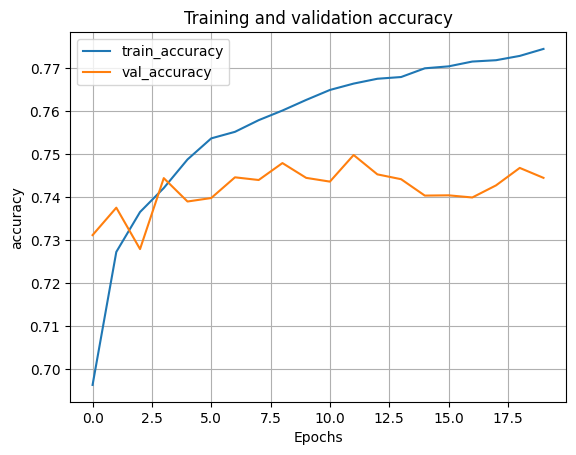

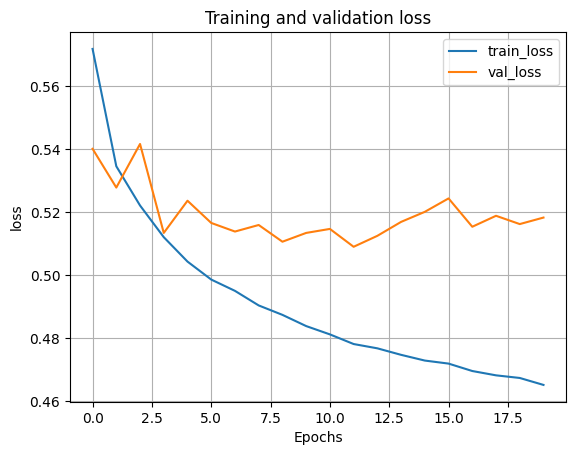

In [ ]:
# Plot the accuracy and loss history
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')